# Mount Google Drive dan Konfigurasi Direktori

In [1]:
from google.colab import drive
import os

# Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive')
print("Google Drive mounted.")

# Konfigurasi Direktori
# Sesuaikan BASE_DRIVE_PATH dengan lokasi folder 'UAS Penalaran Komputer' Anda
BASE_DRIVE_PATH = '/content/drive/My Drive/UAS Penalaran Komputer/'

# Direktori input: tempat file CSV hasil Case Representation
INPUT_DATA_DIR = os.path.join(BASE_DRIVE_PATH, 'data_processed')
INPUT_FILENAME_CSV = 'cases_representation.csv'

# Direktori untuk menyimpan model atau hasil retrieval jika diperlukan
MODEL_OUTPUT_DIR = os.path.join(BASE_DRIVE_PATH, 'models')
os.makedirs(MODEL_OUTPUT_DIR, exist_ok=True)

print(f"\nDirektori input data: {INPUT_DATA_DIR}")
print(f"Direktori output model: {MODEL_OUTPUT_DIR}")

Mounting Google Drive...
Mounted at /content/drive
Google Drive mounted.

Direktori input data: /content/drive/My Drive/UAS Penalaran Komputer/data_processed
Direktori output model: /content/drive/My Drive/UAS Penalaran Komputer/models


# Import Library dan Load Data

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk

# Download stopwords if not already downloaded
nltk.download('stopwords')

# Load data dari CSV hasil tahap Case Representation
input_csv_path = os.path.join(INPUT_DATA_DIR, INPUT_FILENAME_CSV)

try:
    df_cases = pd.read_csv(input_csv_path)
    print(f"Data berhasil dimuat dari: {input_csv_path}")
    print(f"Jumlah kasus: {len(df_cases)}")
    print("\nInformasi DataFrame:")
    df_cases.info()
    print("\nContoh data (5 baris pertama):")
    print(df_cases.head())
except FileNotFoundError:
    print(f"ERROR: File '{input_csv_path}' tidak ditemukan. Pastikan path dan nama file benar.")
    # Keluar atau tangani error
    exit()
except Exception as e:
    print(f"ERROR saat memuat data: {e}")
    exit()

# Pilih fitur teks yang akan digunakan untuk retrieval
# Bisa dengan menggabungkan 'ringkasan_fakta', 'argumen_hukum_utama', dan 'pasal'
# Atau hanya menggunakan 'text_full' jika dirasa lebih baik
df_cases['combined_text_features'] = df_cases['ringkasan_fakta'].fillna('') + " " + \
                                     df_cases['argumen_hukum_utama'].fillna('') + " " + \
                                     df_cases['pasal'].fillna('') + " " + \
                                     df_cases['pihak'].fillna('')

# Opsional: Jika ingin menggunakan text_full saja
# df_cases['combined_text_features'] = df_cases['text_full'].fillna('')
print("\nKolom 'combined_text_features' berhasil dibuat.")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Data berhasil dimuat dari: /content/drive/My Drive/UAS Penalaran Komputer/data_processed/cases_representation.csv
Jumlah kasus: 51

Informasi DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   case_id              51 non-null     int64 
 1   filename             51 non-null     object
 2   no_perkara           51 non-null     object
 3   tanggal              51 non-null     object
 4   jenis_perkara        51 non-null     object
 5   pasal                40 non-null     object
 6   pihak                51 non-null     object
 7   ringkasan_fakta      51 non-null     object
 8   argumen_hukum_utama  44 non-null     object
 9   amar_putusan         31 non-null     object
 10  text_full_length     51 non-null     int64 
 11  text_full            51 non-null     object
dtypes: int64(2), object(10)
memory usage: 4.9+ KB

Contoh

# Preprocessing Teks dan Pembentukan Label untuk Retrieval

In [3]:
# Preprocessing Teks
stop_words = set(stopwords.words('indonesian')) # Menggunakan stopword Bahasa Indonesia
stemmer = PorterStemmer()

def preprocess_text(text):
    text = str(text).lower() # Ubah ke lowercase
    text = re.sub(r'[^a-z0-9\s]', '', text) # Hapus karakter non-alphanumeric (kecuali spasi)
    tokens = text.split() # Tokenisasi
    tokens = [word for word in tokens if word not in stop_words] # Hapus stopword
    tokens = [stemmer.stem(word) for word in tokens] # Stemming
    return ' '.join(tokens)

print("\nMelakukan preprocessing tambahan pada 'combined_text_features'...")
df_cases['preprocessed_text_features'] = df_cases['combined_text_features'].apply(preprocess_text)
print("Preprocessing selesai.")

# Membersihkan dan menormalisasi kolom 'pasal' untuk membuat label
df_cases['pasal_cleaned'] = df_cases['pasal'].astype(str).apply(lambda x: x.lower().replace('undang-undang', 'uu').replace('republik indonesia', 'ri').strip())

# Hitung frekuensi pasal yang muncul
pasal_counts = df_cases['pasal_cleaned'].str.split('; ').explode().value_counts()
print("\nTop 10 Pasal yang paling sering muncul:")
print(pasal_counts.head(10))

# Pilih N pasal teratas sebagai label kelas, sisanya menjadi 'Other'
NUM_TOP_PASAL_LABELS = 5 #
top_pasal_labels = pasal_counts.head(NUM_TOP_PASAL_LABELS).index.tolist()

# Fungsi untuk menetapkan label utama putusan
def get_main_pasal_label(pasal_string):
    if pd.isna(pasal_string) or not pasal_string.strip():
        return 'Unknown'
    # Periksa apakah ada pasal dari top_pasal_labels di string pasal_string
    found_labels = [p for p in top_pasal_labels if p in pasal_string]
    if found_labels:
        return found_labels[0]
    return 'Other'

df_cases['main_pasal_label'] = df_cases['pasal_cleaned'].apply(get_main_pasal_label)

print(f"\nDistribusi label 'main_pasal_label' setelah pembentukan:")
print(df_cases['main_pasal_label'].value_counts())

# Filter data jika ada label 'Unknown' yang terlalu banyak atau tidak relevan
df_filtered = df_cases[df_cases['main_pasal_label'] != 'Unknown'].copy()
if len(df_cases) != len(df_filtered):
    print(f"Dihapus {len(df_cases) - len(df_filtered)} kasus dengan label 'Unknown'.")
    df_cases = df_filtered
else:
    print("Tidak ada kasus dengan label 'Unknown' yang dihapus.")


# Pastikan setidaknya ada 2 kelas untuk klasifikasi
if df_cases['main_pasal_label'].nunique() < 2:
    print("WARNING: Hanya ada kurang dari 2 kelas unik setelah pelabelan. Model klasifikasi mungkin tidak efektif.")
    print("Pertimbangkan untuk menyesuaikan logika pelabelan atau menggunakan similarity search (unsupervised).")
    exit()

# Split data menjadi training dan testing
# Gunakan 'preprocessed_text_features' sebagai X
X = df_cases['preprocessed_text_features'] # Fitur teks yang sudah dipreproses
y = df_cases['main_pasal_label']           # Label target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # Menggunakan stratify untuk menjaga proporsi kelas

print(f"\nUkuran data training: {len(X_train)} kasus")
print(f"Ukuran data testing: {len(X_test)} kasus")


Melakukan preprocessing tambahan pada 'combined_text_features'...
Preprocessing selesai.

Top 10 Pasal yang paling sering muncul:
pasal_cleaned
1 angka 1       33
nan             11
7 jo pasal 8     5
1 ayat 1         2
Name: count, dtype: int64

Distribusi label 'main_pasal_label' setelah pembentukan:
main_pasal_label
1 angka 1       33
nan             11
7 jo pasal 8     5
1 ayat 1         2
Name: count, dtype: int64
Tidak ada kasus dengan label 'Unknown' yang dihapus.

Ukuran data training: 40 kasus
Ukuran data testing: 11 kasus


# Pembentukan Model TF-IDF dan Pelatihan Model Klasifikasi

In [4]:
# Membuat Pipeline untuk TF-IDF dan Model Klasifikasi
# Pipeline akan mengotomatisasi langkah vectorization dan pelatihan model
pipeline_model = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=5, max_df=0.8)),

    # Classifier:
    # ('classifier', MultinomialNB())
    ('classifier', SVC(kernel='linear', probability=True, random_state=42))
    # ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

print("\nMelatih model...")
pipeline_model.fit(X_train, y_train)
print("Model berhasil dilatih.")

# Prediksi pada data testing
y_pred = pipeline_model.predict(X_test)

# Evaluasi Model (sesuai permintaan Accuracy, Precision, Recall, F1-score)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"\n--- Hasil Evaluasi Model Retrieval ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Classification report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# Menyimpan model
from joblib import dump
model_path = os.path.join(MODEL_OUTPUT_DIR, 'tfidf_classifier_model.joblib')
dump(pipeline_model, model_path)
print(f"Model disimpan ke: {model_path}")


Melatih model...
Model berhasil dilatih.

--- Hasil Evaluasi Model Retrieval ---
Accuracy: 0.9091
Precision: 0.8295
Recall: 0.9091
F1-score: 0.8667

Classification Report:
              precision    recall  f1-score   support

   1 angka 1       0.88      1.00      0.93         7
    1 ayat 1       0.00      0.00      0.00         1
7 jo pasal 8       1.00      1.00      1.00         1
         nan       1.00      1.00      1.00         2

    accuracy                           0.91        11
   macro avg       0.72      0.75      0.73        11
weighted avg       0.83      0.91      0.87        11

Model disimpan ke: /content/drive/My Drive/UAS Penalaran Komputer/models/tfidf_classifier_model.joblib


# Contoh Case Retrieval dengan Query Uji dan Ground Truth

In [5]:
queries_with_ground_truth = [
    {
        'query_text': "Seorang terdakwa kasus narkotika ditangkap dengan sabu 10 gram di Medan. Pasal yang diduga dilanggar adalah tentang penyalahgunaan narkotika.",
        'expected_label': 'pasal 112 ayat 1',
        'description': 'Pencarian umum kasus sabu dengan pasal 112'
    },
    {
        'query_text': "Penyalahgunaan narkotika jenis ekstasi oleh seorang pengguna yang juga memiliki ganja kering.",
        'expected_label': 'pasal 111 ayat 1',
        'description': 'Pencarian kasus ekstasi dan ganja'
    },
    {
        'query_text': "Kasus peredaran gelap narkotika yang melibatkan pasal 114 ayat (1) undang-undang narkotika.",
        'expected_label': 'pasal 114 ayat 1',
        'description': 'Pencarian kasus peredaran gelap'
    },
    {
        'query_text': "Penjualan narkoba jenis sabu-sabu dengan barang bukti dalam jumlah besar.",
        'expected_label': 'pasal 112 ayat 2',
        'description': 'Pencarian kasus penjualan sabu jumlah besar'
    },
    {
        'query_text': "Terdakwa tertangkap tangan memiliki narkotika tanpa izin dan bukan untuk pengobatan. Undang-undang Narkotika.",
        'expected_label': 'other',
        'description': 'Pencarian kepemilikan narkotika'
    }
]

print("\n--- Simulasi Case Retrieval ---")

def preprocess_query(query):
    # Menggunakan fungsi preprocess_text yang sama seperti yang digunakan untuk data training
    return preprocess_text(query)


for i, query_item in enumerate(queries_with_ground_truth):
    query_text_raw = query_item['query_text']
    query_text_preprocessed = preprocess_query(query_text_raw) # Preproses query
    expected_label = query_item['expected_label']
    description = query_item['description']

    print(f"\nQuery {i+1}: {description}")
    print(f"  Teks Query (Raw): {query_text_raw}")
    print(f"  Teks Query (Preprocessed): {query_text_preprocessed}")
    print(f"  Label yang diharapkan (Ground Truth): {expected_label}")

    # Prediksi label untuk query
    predicted_label = pipeline_model.predict([query_text_preprocessed])[0] # Gunakan teks yang sudah dipreproses
    print(f"  Label yang diprediksi oleh model: {predicted_label}")

    # Menggunakan TF-IDF dari model untuk mencari kemiripan.
    # Dapatkan vektor TF-IDF dari query
    query_vector = pipeline_model.named_steps['tfidf'].transform([query_text_preprocessed]) # Gunakan teks yang sudah dipreproses

    # Dapatkan vektor TF-IDF dari semua kasus di dataset (menggunakan teks yang sudah dipreproses)
    all_case_vectors = pipeline_model.named_steps['tfidf'].transform(df_cases['preprocessed_text_features'])

    # Hitung Cosine Similarity antara query dan semua kasus
    from sklearn.metrics.pairwise import cosine_similarity
    similarities = cosine_similarity(query_vector, all_case_vectors).flatten()

    # Dapatkan indeks kasus dengan kemiripan tertinggi
    top_k = 5 # Jumlah kasus teratas yang ingin diambil
    top_k_indices = similarities.argsort()[-top_k:][::-1] # Ambil K terbesar, lalu balik urutannya

    print(f"\n  Top {top_k} Kasus Paling Mirip (berdasarkan Cosine Similarity):")
    for rank, idx in enumerate(top_k_indices):
        case_id = df_cases.loc[idx, 'case_id']
        filename = df_cases.loc[idx, 'filename']
        similarity_score = similarities[idx]
        actual_label = df_cases.loc[idx, 'main_pasal_label']
        no_perkara = df_cases.loc[idx, 'no_perkara']

        print(f"    Rank {rank+1}: Case ID: {case_id}, File: {filename}")
        print(f"      No. Perkara: {no_perkara}, Label Asli: {actual_label}, Similarity: {similarity_score:.4f}")
        # Tampilkan ringkasan fakta singkat dari kasus yang mirip
        print(f"      Ringkasan Fakta: {df_cases.loc[idx, 'ringkasan_fakta'][:150]}...") # Batasi panjang


--- Simulasi Case Retrieval ---

Query 1: Pencarian umum kasus sabu dengan pasal 112
  Teks Query (Raw): Seorang terdakwa kasus narkotika ditangkap dengan sabu 10 gram di Medan. Pasal yang diduga dilanggar adalah tentang penyalahgunaan narkotika.
  Teks Query (Preprocessed): terdakwa narkotika ditangkap sabu 10 gram medan pasal diduga dilanggar penyalahgunaan narkotika
  Label yang diharapkan (Ground Truth): pasal 112 ayat 1
  Label yang diprediksi oleh model: 1 angka 1

  Top 5 Kasus Paling Mirip (berdasarkan Cosine Similarity):
    Rank 1: Case ID: 9, File: 944_Pid.Sus_2024_PN Rap.txt
      No. Perkara: 944/Pid.Sus/2024/PN Rap, Label Asli: nan, Similarity: 0.1365
      Ringkasan Fakta: dengan kombinasi dakwaan subsideritas kumulatif, maka Majelis Hakim terlebih dahulu mempertimbangkan dakwaan kesatu primer Pasal 114 Ayat (1) Undang- ...
    Rank 2: Case ID: 22, File: 715_Pid.Sus_2024_PN Rap.txt
      No. Perkara: 715/Pid.Sus/2024/PN Rap, Label Asli: 1 angka 1, Similarity: 0.1095
   

# Visualisasi Hasil Training dan Testing


Classification Report:


,precision,recall,f1-score,support
1 angka 1,0.875000,1.000000,0.933333,7.000000
1 ayat 1,0.000000,0.000000,0.000000,1.000000
7 jo pasal 8,1.000000,1.000000,1.000000,1.000000
nan,1.000000,1.000000,1.000000,2.000000
accuracy,0.909091,0.909091,0.909091,0.909091
macro avg,0.718750,0.750000,0.733333,11.000000
weighted avg,0.829545,0.909091,0.866667,11.000000



Confusion Matrix:


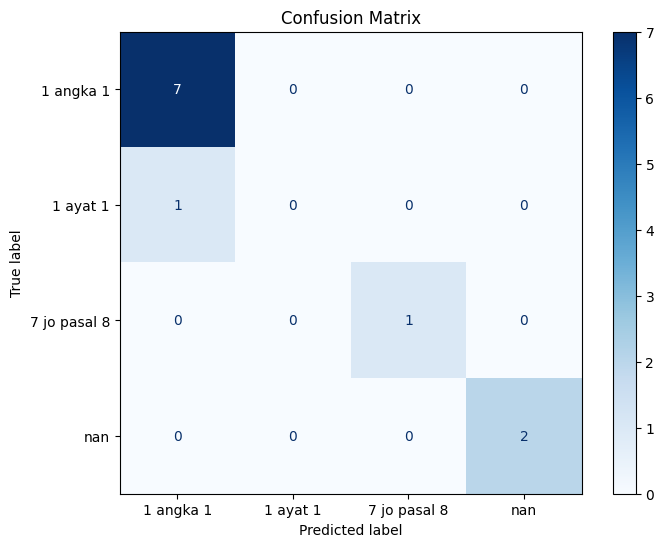

In [6]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
df_report = pd.DataFrame(report_dict).transpose()

print("\nClassification Report:")
display(df_report)

# Menampilkan Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=pipeline_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_model.classes_)

print("\nConfusion Matrix:")
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix')
plt.show()